In [4]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [5]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
paradigm = np.vstack([sfs_seq, con_seq])


In [6]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [7]:
parameters = pd.DataFrame({
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  40.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amplitude'         : np.array([   1.00,   1.00,   1.00,   2.00,]), # [fMRI parameters]
    'baseline'          : np.array([   0.00,   0.00,   1.00,   0.00,]), # 
    # 'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    # 'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }).astype('float32')



In [8]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

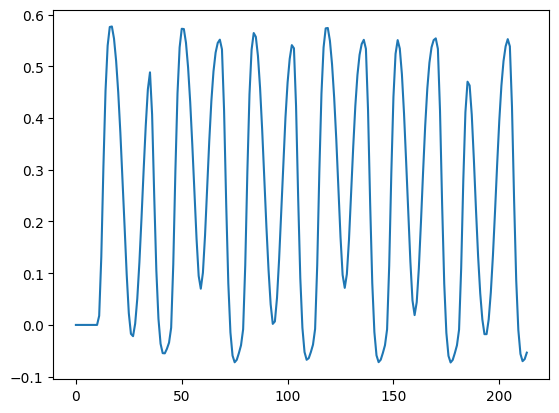

In [9]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred.iloc[:,0])

# MCMC - lets explore...

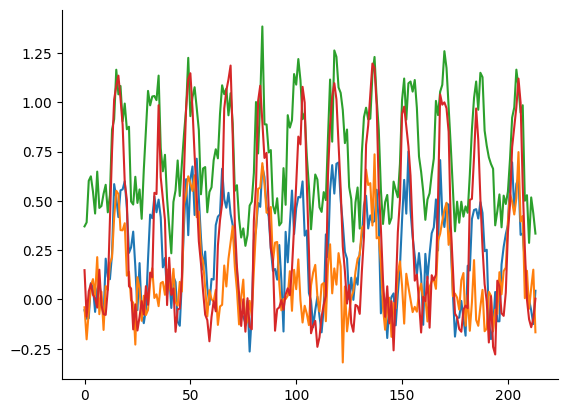

In [13]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [284]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
fitter = BPRF(model, data)
cfitter = ParameterFitter(model, data, model.paradigm)

In [285]:
grid_pars = cfitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 3, 10),
    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
ols_pars

Working with chunk size of 778816
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.333333,2.666667,183.333328,0.68,1.666667,1.000000,0.000000
1,2.000000,1.333333,83.333336,0.68,1.222222,1.000000,0.000000
2,1.000000,4.666667,83.333336,0.68,2.333333,0.958017,0.759900
3,1.000000,2.000000,50.000000,0.68,3.000000,1.695500,0.037244


In [408]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.67, 0.69],     # we fix width_l in our model
    'crf_exp'   : [0, 10] ,
    'amplitude' : [0, 1000],       # Amplitude of TC
    'baseline'  : [-2,2]
}

In [409]:
for b in bounds.keys():
    fitter.add_prior(
        pid=b,
        prior_type='uniform', 
        vmin=bounds[b][0],
        vmax=bounds[b][1],
    )

In [435]:
init_pars = {
    'width_r' : np.ones(4) * 1,
    'SFp' : np.ones(4) * 3,
    'CSp' : np.ones(4) * 100,
    'width_l' : np.ones(4) * 0.68,
    'crf_exp' : np.ones(4) * 1,
    'amplitude' : np.ones(4) * 1, 
    'baseline' : np.ones(4) * 0, 
}
init_pars = pd.DataFrame(init_pars)
init_pars

,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
0,1.0,3.0,100.0,0.68,1.0,1.0,0.0
1,1.0,3.0,100.0,0.68,1.0,1.0,0.0
2,1.0,3.0,100.0,0.68,1.0,1.0,0.0
3,1.0,3.0,100.0,0.68,1.0,1.0,0.0


tf.Tensor(-201.88747, shape=(), dtype=float32)


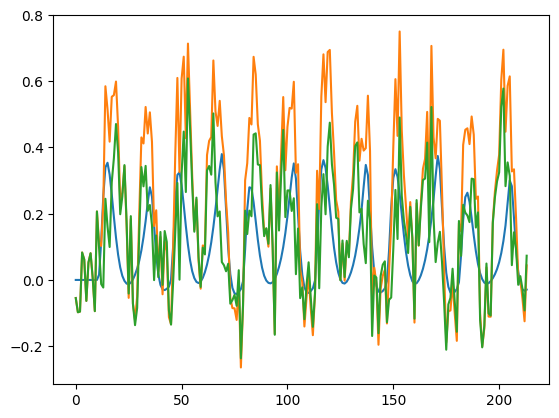

In [ ]:
# init_guesses = model.predict(parameters=init_pars)
# plt.plot(init_guesses.iloc[:,0])
# plt.plot(data.iloc[:,0])

# residuals = data.iloc[:,0] - init_guesses.iloc[:,0]
# residuals

# normal_dist = tfp.distributions.Normal(loc=0.0, scale=1)
# log_prob = normal_dist.log_prob(residuals)
# log_prob = tf.reduce_sum(log_prob)
# print(log_prob)
# plt.plot(residuals)

In [445]:
a = fitter.fit(
    num_results=10000,
    init_pars=init_pars, #ols_pars,
    # fixed_pars={'baseline' : 0.0}
)

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 4
Running HMC...
(1, 7)
width_r
SFp
CSp
crf_exp
amplitude
baseline
width_l


 ...]

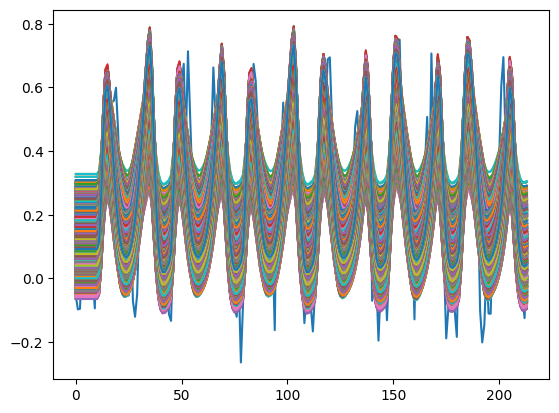

In [432]:
pred = model.predict(parameters=a.loc[45000:,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

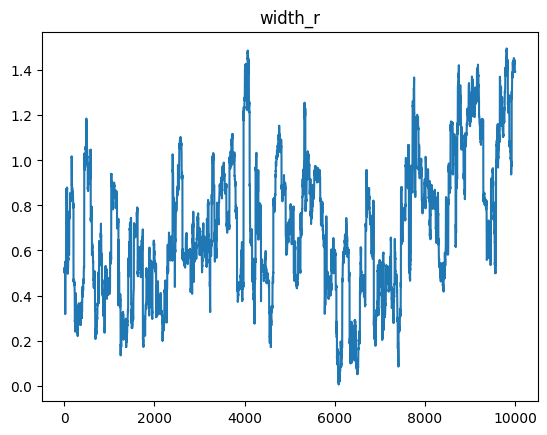

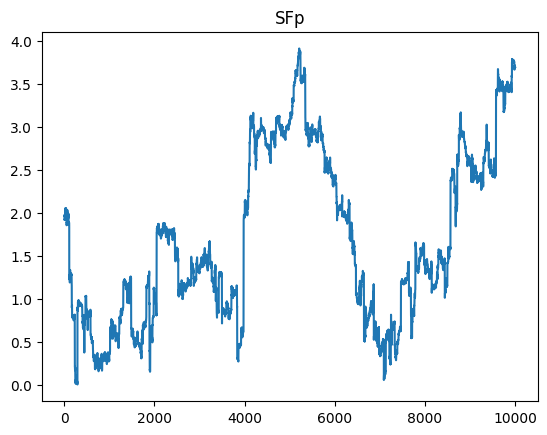

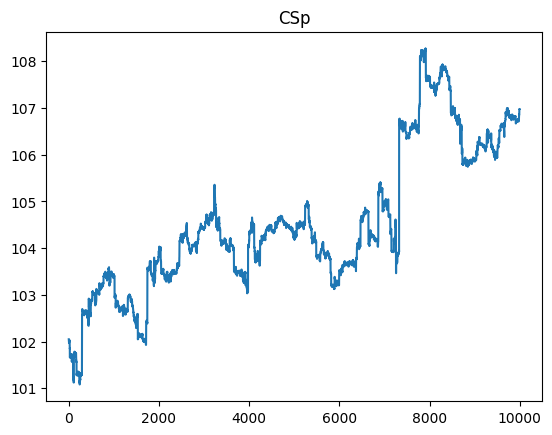

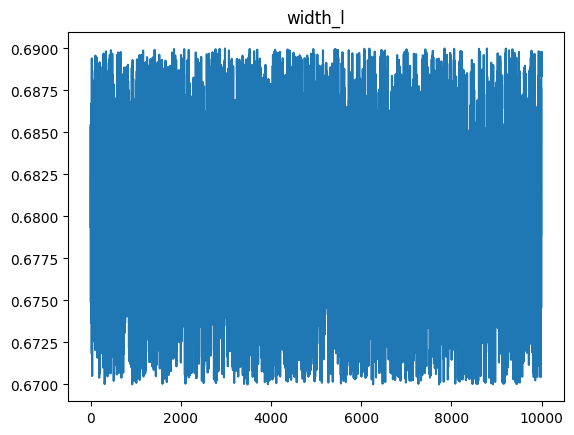

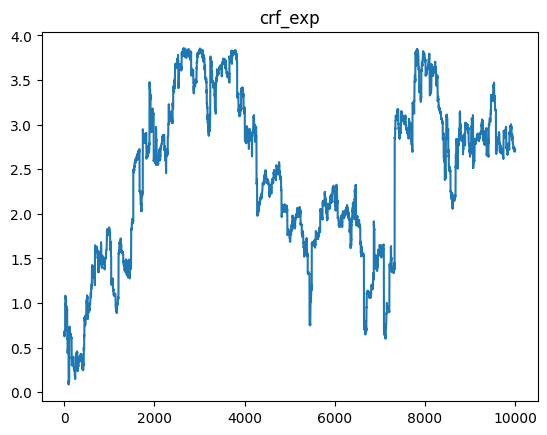

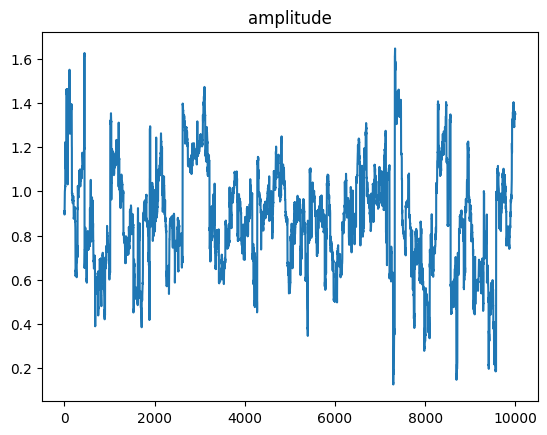

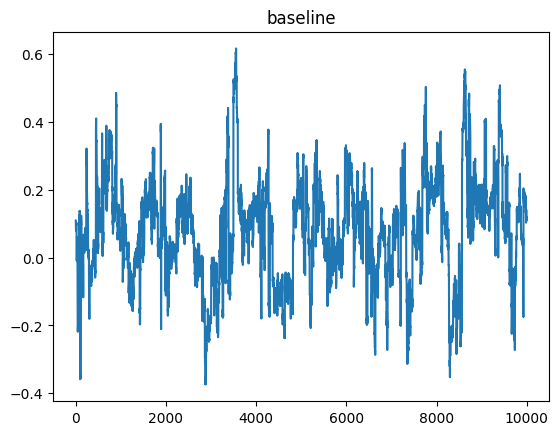

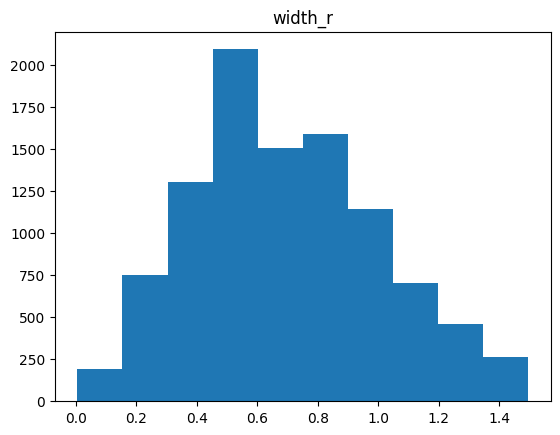

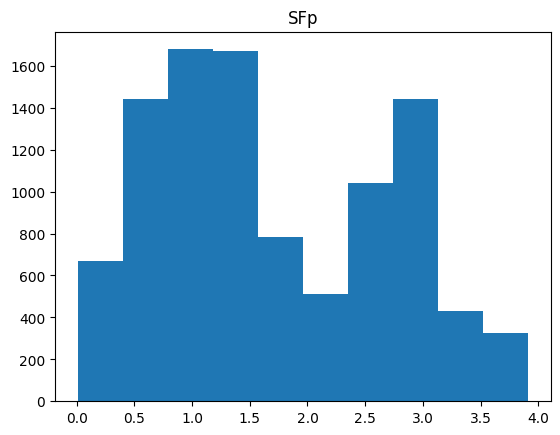

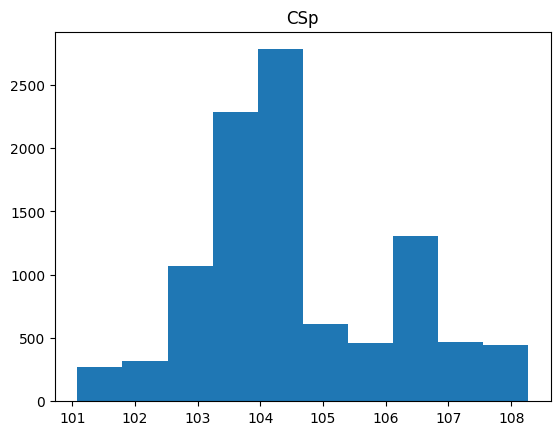

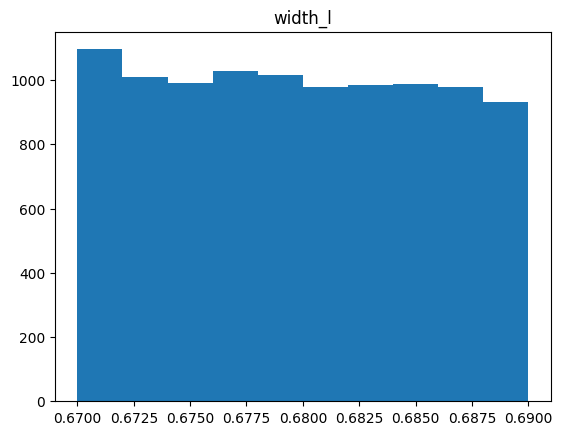

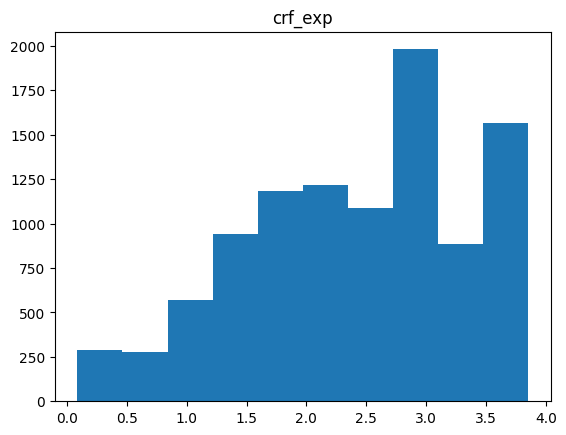

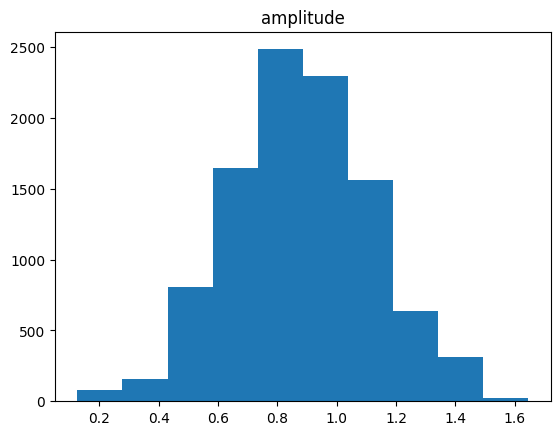

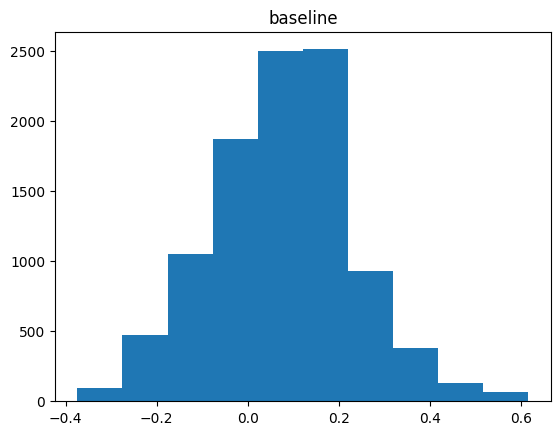

In [446]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

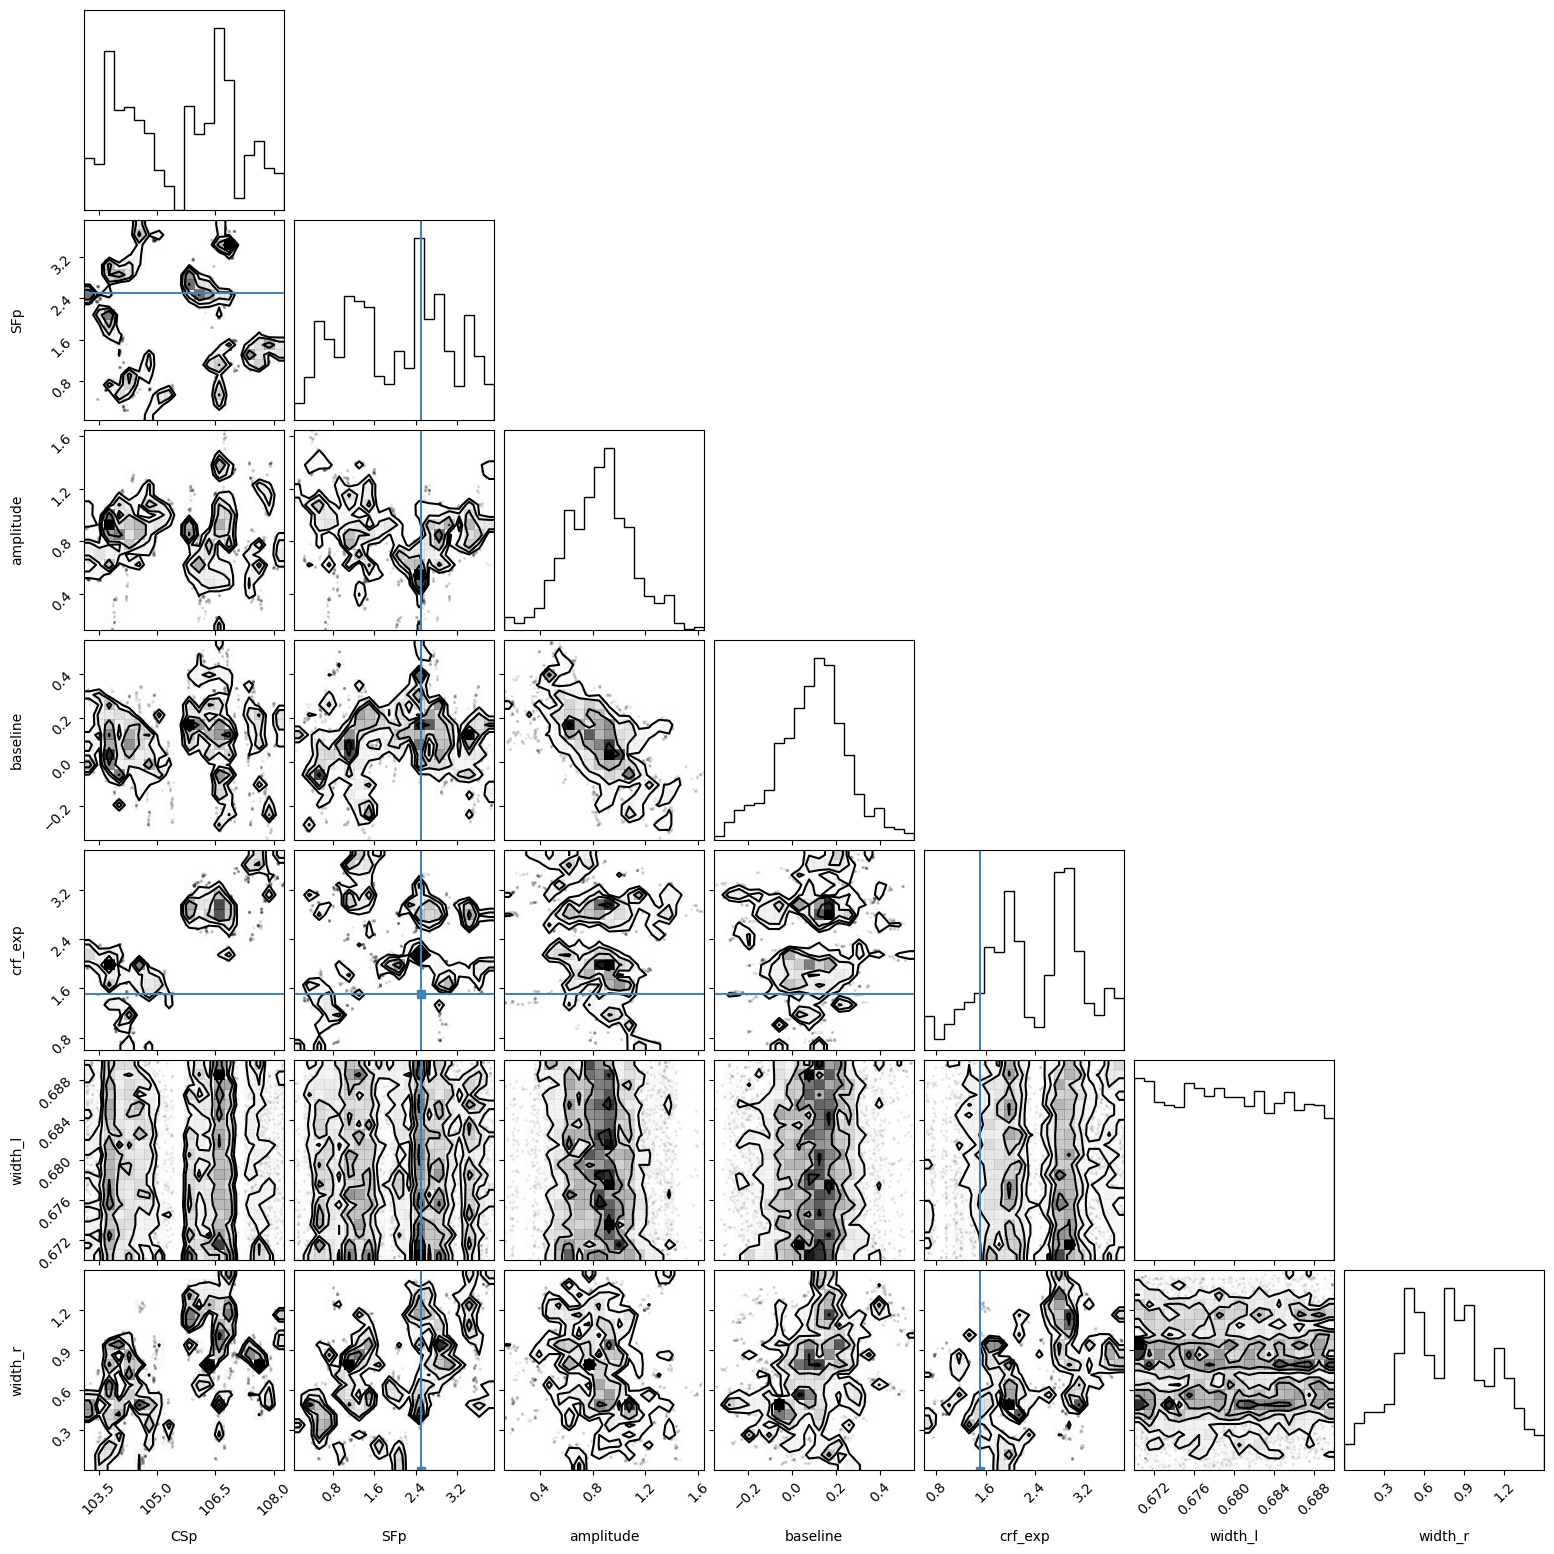

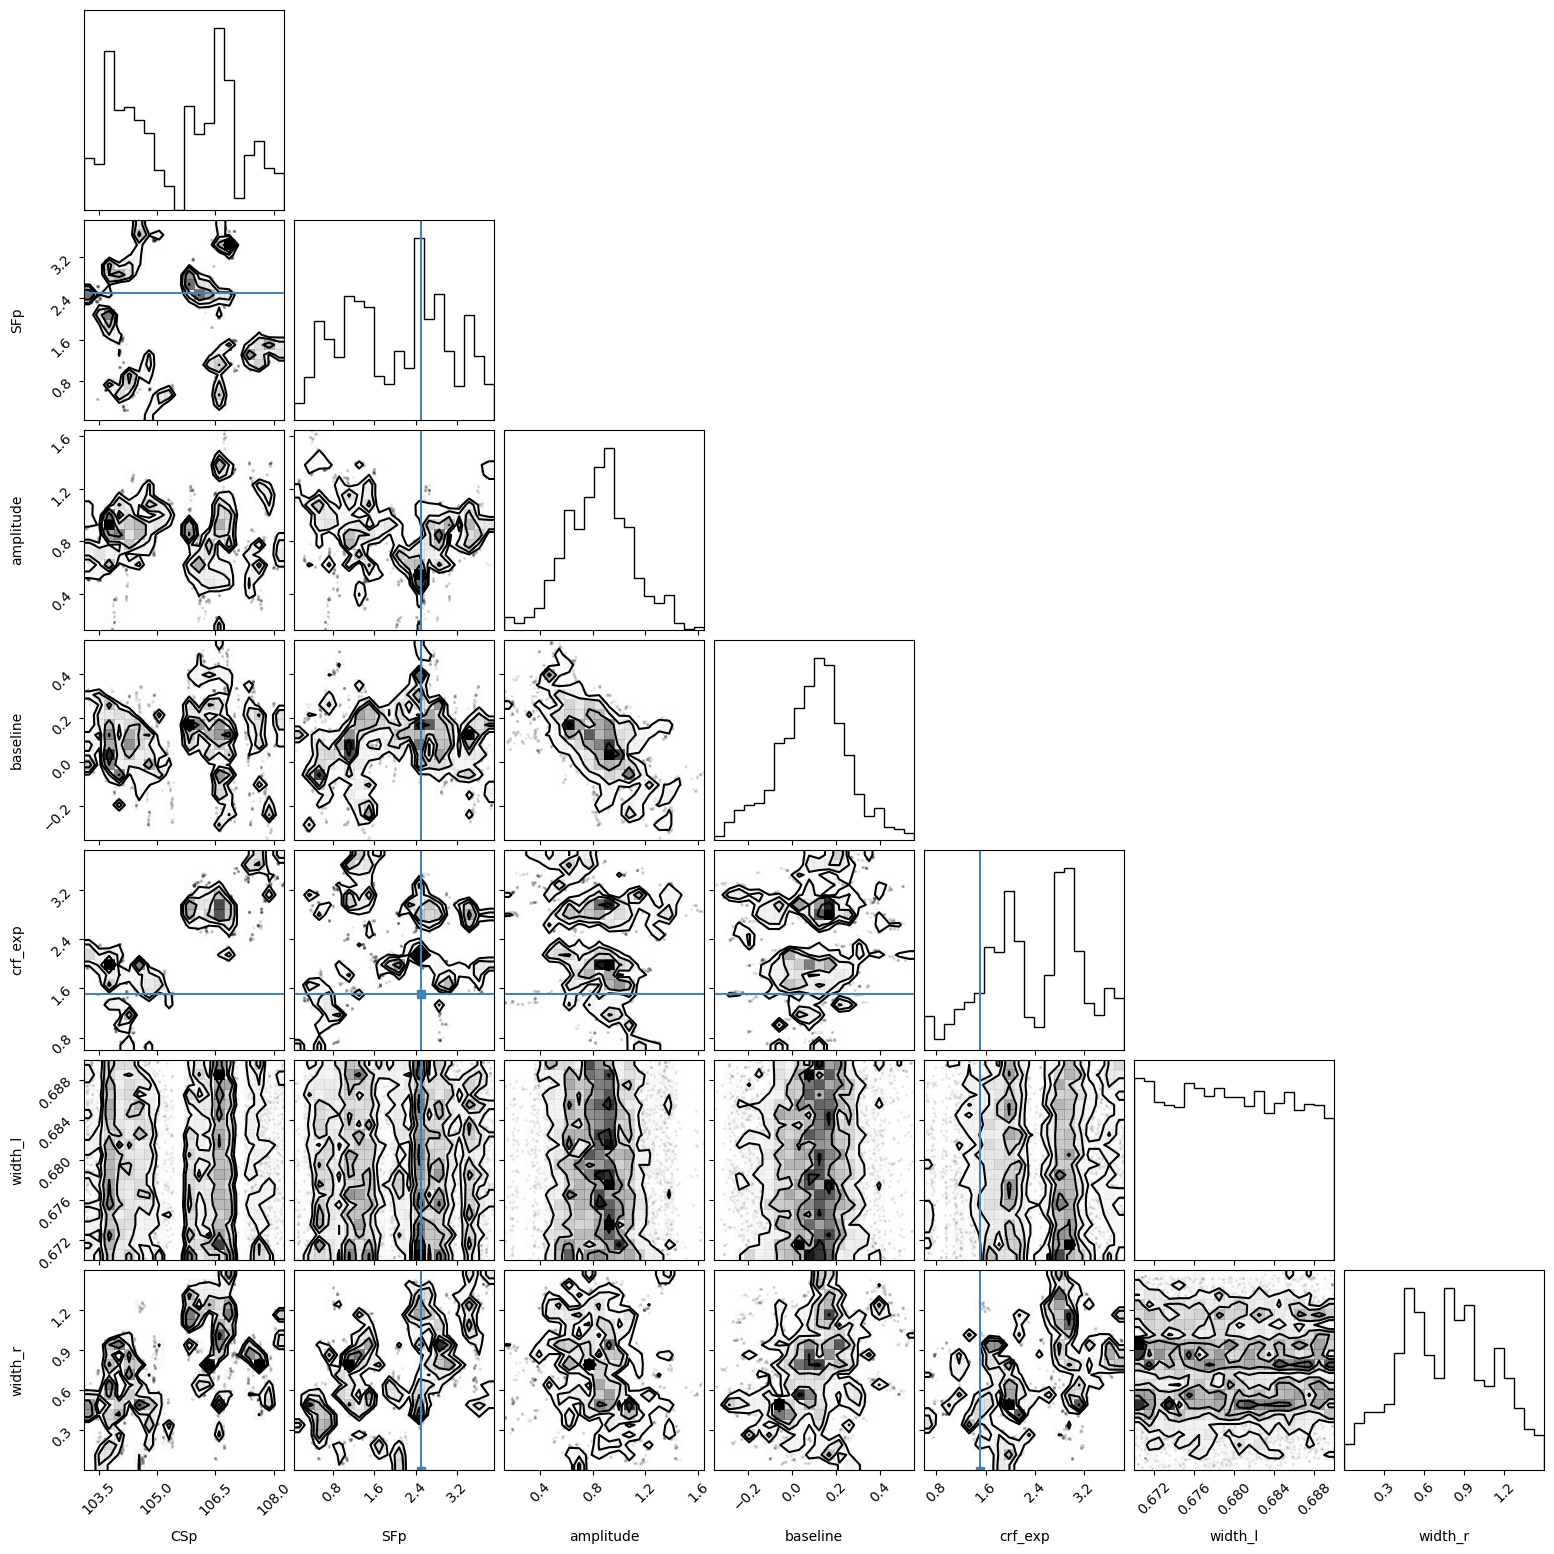

In [474]:
import corner as corner
corner.corner(
    a.iloc[5000:,:], truths=parameters.iloc[0,:].T
)
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [471]:
parameters.keys()
a.keys()

Index(['width_r', 'SFp', 'CSp', 'width_l', 'crf_exp', 'amplitude', 'baseline'], dtype='object')

In [461]:
parameters

,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.28,2.5,166.0,0.68,1.5,1.0,0.0
1,1.50,1.0,100.0,0.68,1.5,1.0,0.0
2,1.00,4.0,80.0,0.68,2.5,1.0,1.0
3,1.00,2.0,40.0,0.68,3.0,2.0,0.0


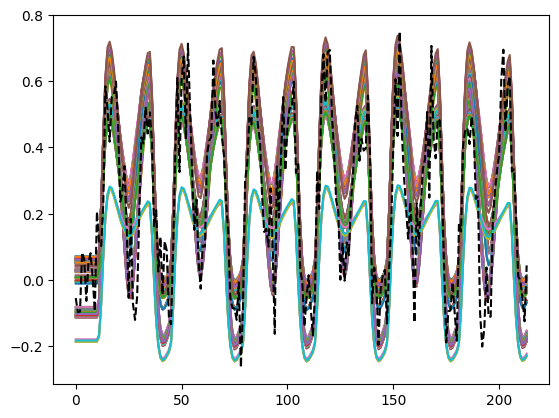

In [439]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [324]:
data.iloc[:,0]

0     -0.054636
1     -0.097612
2     -0.095491
3      0.082809
4      0.061826
         ...   
209    0.010752
210   -0.000710
211   -0.055781
212   -0.124823
213    0.043897
Name: 0, Length: 214, dtype: float32

In [ ]:
Code

In [146]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

KeyError: "None of [Index(['width_r', 'SFp', 'CSp', 'width_l', 'crf_exp', 'amplitude', 'baseline'], dtype='object', name='parameter')] are in the [columns]"

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

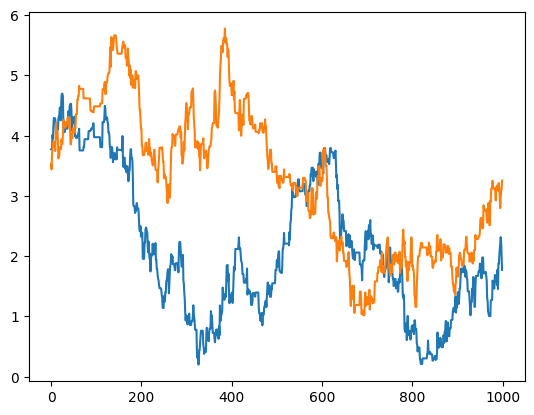

In [98]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [32]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))


<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[1.3333334e+00, 2.6666667e+00, 1.8333333e+02, 6.8000001e-01,
        1.6666666e+00, 5.4132485e-01, 0.0000000e+00],
       [2.0000000e+00, 1.3333334e+00, 8.3333336e+01, 6.8000001e-01,
        1.2222222e+00, 5.4132485e-01, 0.0000000e+00],
       [1.0000000e+00, 4.6666665e+00, 8.3333336e+01, 6.8000001e-01,
        2.3333333e+00, 4.7407174e-01, 7.5990015e-01],
       [1.0000000e+00, 2.0000000e+00, 5.0000000e+01, 6.8000001e-01,
        3.0000000e+00, 1.4927620e+00, 3.7244350e-02]], dtype=float32)>